### Кластеризация

In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import warnings
import os
earn_list = ['10100000000000000',
             '10300000000000000',
             '10500000000000000',
             '10600000000000000',
             '10700000000000000',
             '10800000000000000',
             '11200000000000000',
             '11300000000000000',
             '11400000000000000',
             '11600000000000000',
             '11700000000000000',
             '20000000000000000',
             '20200000000000000',
             '20210000000000150',
             '20215001000000150',
             '20220000000000150',

             'X']

cost_list = ['100',
             '200',
             '300',
             '400',
             '500',
             '600',
             '700',
             '800',
             '900',
             '1000',
             '1100',
             '1200',
             '1300',
             'х']

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

##### Основной 2024 год
Из него возьмем таблицу scoring

In [2]:
vrp = pd.read_excel('VRP_s1998.xlsx', sheet_name='2')
original_names = [i.lower() for i in vrp.iloc[3:96, 0].to_list() if 'федеральный' not in i.lower().split(' ')]

vrp = vrp.reset_index(drop = True).fillna(0).set_axis(['name', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], axis = 1)
vrp.loc[:, 'name'] = vrp.loc[:, 'name'].apply(lambda x: str(x).lower())

vrp = vrp.set_index('name').loc[original_names,:]

years = {} # словарь куда будут складываться данные по годам

In [3]:
# Получить путь к текущему .ipynb-файлу
notebook_path = os.path.abspath(".")

# Установить рабочую директорию к папке с файлами
os.chdir(notebook_path)
papka = 'cluster_data'
# Проверка
print("Текущая рабочая директория:", os.getcwd(), f'\nОттуда буду брать данные, там должна быть папка {papka} а в ней данные по годам')

path = notebook_path + f'\\{papka}' # провалимся в папку дата

list_with_years = os.listdir(path) # в папке дата лежит много папок по годам, используем их как список годов
year = list_with_years[-1]
list_with_files = os.listdir(path + f'\\{year}')

Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\roskazna_2 
Оттуда буду брать данные, там должна быть папка cluster_data а в ней данные по годам


In [4]:
names = []
for file in list_with_files:
    df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Д')
    df = df.set_axis([i for i in range(df.shape[1])], axis=1)
    
    names += [df.iloc[4,3]+ ' ' + df.iloc[5,3]]



#cleaning before matching
tollerance_rate = 75
exc_list = ['-', '(', ')']
exc_list_types = ['министерств', 'республик', 'финансов', 'областн', 'бюджет', 'департамент', 'окружно', 'республиканск', 'области', 'по', 'областной',
            'автономно', 'округ', 'экономики', 'политики', 'город', 'муниципальн', 'образовани', 'город', 'управлени', 'правительств', 'в т.ч.', 'и',
            'комитет', 'государственн', 'главное', 'бюджетн', 'народной', 'финанс', 'края', 'имущественн', 'отношени', 'краево', 'контрол', 'край']
cleaned = []
for i in names:
    x = i.lower()
    for letter in exc_list:
        x = x.replace(letter, '')
    x = list(set(x.split(' ')))
    for j in exc_list_types:
        ratio_list = [(fuzz.token_set_ratio(i,j), i) for i in x]
        if len(ratio_list) != 0:
            max_tuple = max([(fuzz.token_set_ratio(i,j), i) for i in x])
            if max_tuple[0] > tollerance_rate:
                x.remove(max_tuple[1])
        else:
            continue

    cleaned = cleaned + [' '.join(x)]

original_names = [i.lower() for i in original_names]
original = []
for i in original_names:
    x = i.lower()
    for letter in exc_list:
        x = x.replace(letter, '')
    x = list(set(x.split(' ')))
    for j in exc_list_types:
        ratio_list = [(fuzz.token_set_ratio(i,j), i) for i in x]
        if len(ratio_list) != 0:
            max_tuple = max([(fuzz.token_set_ratio(i,j), i) for i in x])
            if max_tuple[0] > tollerance_rate:
                x.remove(max_tuple[1])
        else:
            continue
        
    original = original + [' '.join(x)]
    
tuples_list = [max([(fuzz.token_set_ratio(i,j),i, j) for j in cleaned]) for i in original]
scoring = pd.DataFrame(tuples_list, columns = ['score', 'original', 'cleaned'])
doubling = scoring.cleaned.value_counts().loc[(scoring.cleaned.value_counts() > 1).values].index.to_list()
drop = pd.DataFrame(columns = scoring.columns)
for i in range(len(doubling)):
    temp_df = scoring.loc[list(map(bool, (scoring == doubling[i]).sum(1).to_list())), :].sort_values(by = 'score', ascending = False)
    print(temp_df.iloc[0,:].to_list())
    drop = pd.concat([drop if not drop.empty else None, temp_df.iloc[1:,:]])
scoring = scoring.loc[[i not in drop.original.to_list() for i in scoring.original.to_list()],:].copy()
wrong_guesses = {k:[v] for k, v in zip(drop.original.to_list(), drop.cleaned.to_list())}
counter = 0
while counter < 100:
    tuples_list = []
    for w_g in wrong_guesses.keys():
        pos_guesses = cleaned.copy()
        for not_p_g in wrong_guesses[w_g]:
            pos_guesses.remove(not_p_g)
        tuples_list = tuples_list + [max([(fuzz.token_set_ratio(w_g,j),w_g, j) for j in pos_guesses])]
    scoring = pd.concat([scoring, pd.DataFrame(tuples_list, columns = ['score', 'original', 'cleaned'])])
    
    # break point
    if sum((scoring.cleaned.value_counts() > 1).values) == 0:
        break

    doubling = scoring.cleaned.value_counts().loc[(scoring.cleaned.value_counts() > 1).values].index.to_list()
    drop = pd.DataFrame(columns = scoring.columns)
    for i in range(len(doubling)):
        temp_df = scoring.loc[list(map(bool, (scoring == doubling[i]).sum(1).to_list())), :].sort_values(by = 'score', ascending = False)
        print(temp_df.iloc[0,:].to_list())
        drop = pd.concat([drop if not drop.empty else None, temp_df.iloc[1:,:]])
    scoring = scoring.loc[[i not in drop.original.to_list() for i in scoring.original.to_list()],:].copy()
    drop = {k:[v] for k, v in zip(drop.original.to_list(), drop.cleaned.to_list())}
    wrong_guesses_new = {}
    for w_g in drop.keys():
        try:
            wrong_guesses_new[w_g] = wrong_guesses[w_g] + drop[w_g]
        except:
            wrong_guesses_new[w_g] = drop[w_g]
    wrong_guesses = wrong_guesses_new.copy()
    counter = counter + 1
scoring = scoring.reset_index(drop = True).copy()
if scoring.cleaned.unique().shape == scoring.original.unique().shape:
    print("Нет пропущенных регионов")
else:
    print("Есть пропущенные регионы")

scoring['original_names'] = original_names
scoring['names'] = '0'
for i in range(scoring.shape[0]):
    region = scoring.loc[i, 'cleaned']
    iteration_index = 0
    for n in cleaned:
        
        if region == n:
            scoring.loc[i, 'names'] = names[iteration_index]
        iteration_index += 1  

Нет пропущенных регионов


### 2024 год

In [5]:
year = list_with_years[-1]
list_with_files = os.listdir(path + f'\\{year}')

files_regions = {}
year_dict = {'earn':[], 'cost':[]}
for file in list_with_files:
    df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Д')
    df = df.set_axis([i for i in range(df.shape[1])], axis=1)
    

    try:
        name = scoring.query(f'names == "{df.iloc[4,3]+ ' ' + df.iloc[5,3]}"').loc[:, 'original_names'].item()
        files_regions[file.split('_')[0]] = name
    except:
        print(f'Не неайден "{df.iloc[4,3]+ ' ' + df.iloc[5,3]}"')
        continue
    
    
    plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
    plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
    res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
    res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

    region_earn_res = df.iloc[res_index:, res_col-2:]
    region_earn_plan = df.iloc[plan_index:, plan_col-2:res_col-2]
    region_dict = {'name':name}
    for code in earn_list:
        try:
            if code == "X":

                index_value = region_earn_res.loc[region_earn_res.fillna(0).loc[:,res_col-2].copy().isin([f'{code}']).to_list()].index.item()
                region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col]
            else: # специально для москвы, самары и перми
                index_value =region_earn_res.loc[[j == code[:-3] for j in [i[:-3] for i in region_earn_res.fillna(0).loc[:,res_col-1].astype(int).astype(str).to_list()]]].index.item()

                region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col]                

        except:
                print(f"Нет кода: {code}, в доходах")
    
    year_dict['earn'] += [region_dict]

    df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Р')
    df = df.set_axis([i for i in range(df.shape[1])], axis=1).fillna(0)



    plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
    plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
    res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
    res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

    region_cost_res = df.iloc[res_index:, res_col-4:]
    region_cost_plan = df.iloc[plan_index:, plan_col-4:res_col-4]


    region_dict = {'name':name}
    for code in cost_list:
        try:
            if code == 'х':
                index_value = region_cost_res.loc[region_cost_res.loc[:,res_col-4].isin([code])].index[0].item()
                region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
            else:

                index_value = [i and j for i , j in zip(region_cost_res.loc[:,res_col-3].astype(int).astype(str).copy().isin([f'{code}']).to_list(),\
                                                        region_cost_res.loc[:,res_col-1].astype(int).astype(str).copy().isin(['0']).to_list())]
                index_value = region_cost_res.loc[index_value].index.item()
                region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
        except:
            print(f"Нет кода: {code}, в расходах")
    
    year_dict['cost'] += [region_dict]
    years[year] = year_dict

Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ЗАПОРОЖСКОЙ ОБЛАСТИ Бюджет Запорожской области"
Не неайден "АДМИНИСТРАЦИЯ ФЕДЕРАЛЬНОЙ ТЕРРИТОРИИ "СИРИУС" Бюджет федеральной территории "Сириус""
Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ДОНЕЦКОЙ НАРОДНОЙ РЕСПУБЛИКИ Бюджет Донецкой Народной Республики"
Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ЛУГАНСКОЙ НАРОДНОЙ РЕСПУБЛИКИ Бюджет Луганской Народной Республики"
Не неайден "Межрегиональное операционное управление Федерального казначейства Сводный отчет по консолидированным бюджетам субъектов Российской Федерации и территориальным государственным внебюджетным фондам"
Не неайден "УПРАВЛЕНИЕ ФИНАНСОВ АДМИНИСТРАЦИИ ГОРОДА БАЙКОНУР Бюджет города Байконур"
Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ХЕРСОНСКОЙ ОБЛАСТИ Бюджет Херсонской области"


In [6]:
for year in list_with_years[:-1]:

    print(f'{'-'*50} \n Год {year}\n{'-'*50}')

    list_with_files = os.listdir(path + f'\\{year}')

    year_dict = {'earn':[], 'cost':[]}
    for file in list_with_files:
        try:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Д')
        except:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= 'стр.1_2')
        df = df.set_axis([i for i in range(df.shape[1])], axis=1).fillna(0)
        
        f_code = file.split('_')[0]
        try:
            list(files_regions.keys()).index(f_code)
        except:
            print(f'Не неайден "{df.iloc[4,3]+ ' ' + df.iloc[5,3]}"')
            continue


        name = files_regions[f_code]
        
        
        plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
        plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
        res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
        res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

        region_earn_res = df.iloc[res_index:, res_col-2:]
        region_earn_plan = df.iloc[plan_index:, plan_col-2:res_col-2]
        region_dict = {'name':name}
        for code in earn_list:
            try:
                if code == "X":

                    index_value = region_earn_res.loc[region_earn_res.fillna(0).loc[:,res_col-2].copy().isin([f'{code}']).to_list()].index.item()
                    region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col]
                else: # специально для москвы, самары и перми
                    index_value =region_earn_res.loc[[j == code[:-3] for j in [i[:-3] for i in region_earn_res.fillna(0).loc[:,res_col-1].astype(int).astype(str).to_list()]]].index.item()

                    region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col]                

            except:
                    print(f"{name}: нет кода: {code}, в доходах")
        
        year_dict['earn'] += [region_dict]

        try:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Р')
        except:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= 'стр.3_4')
        df = df.set_axis([i for i in range(df.shape[1])], axis=1).fillna(0)



        plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
        plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
        res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
        res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

        region_cost_res = df.iloc[res_index:, res_col-4:]
        region_cost_plan = df.iloc[plan_index:, plan_col-4:res_col-4]


        region_dict = {'name':name}
        for code in cost_list:
            try:
                if code == 'х':
                    index_value = region_cost_res.loc[region_cost_res.loc[:,res_col-4].isin([code])].index[0].item()
                    region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
                else:

                    index_value = [i and j for i , j in zip(region_cost_res.loc[:,res_col-3].astype(int).astype(str).copy().isin([f'{code}']).to_list(),\
                                                            region_cost_res.loc[:,res_col-1].astype(int).astype(str).copy().isin(['0']).to_list())]
                    index_value = region_cost_res.loc[index_value].index.item()
                    region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
            except:
                print(f"{name}: нет кода: {code}, в расходах")
        
        year_dict['cost'] += [region_dict]
        years[year] = year_dict

-------------------------------------------------- 
 Год 2019
--------------------------------------------------
г.москва: нет кода: 20215001000000150, в доходах
г.севастополь: нет кода: 200, в расходах
г.севастополь: нет кода: 1300, в расходах
Не неайден "Межрегиональное операционное управление Федерального казначейства Федеральный бюджет"
Не неайден "УПРАВЛЕНИЕ ФИНАНСОВ АДМИНИСТРАЦИИ ГОРОДА БАЙКОНУР Бюджет Управления финансов администрации города Байконур"
-------------------------------------------------- 
 Год 2020
--------------------------------------------------
г.москва: нет кода: 20215001000000150, в доходах
г.севастополь: нет кода: 200, в расходах
г.севастополь: нет кода: 1300, в расходах
Не неайден "Межрегиональное операционное управление Федерального казначейства СВОДНЫЙ отчет по консолидированным бюджетам субъектов Российской Федерации и территориальным государственным внебюджетным фондам"
Не неайден "УПРАВЛЕНИЕ ФИНАНСОВ АДМИНИСТРАЦИИ ГОРОДА БАЙКОНУР Бюджет Управления фина

In [7]:
earn_list_names = [
    'income_tax',
    'goods_tax',
    'gen_income_tax',
    'property_tax',
    'resourse_tax',
    'gov_fees',
    'polution_tax',
    'gov_service',
    'sells',
    'gov_penalties',
    'rest_income',
    'all_grants',
    'mbt',
    'donat',
    'donat_rbo',
    'subsidies',
    'total'
]
earn_list_names = {k: v for k, v in zip(earn_list, earn_list_names)}

cost_list_names = [
    'gen_gov',
    'military',
    'n_security',
    'n_economy',
    'zhkh',
    'env_protect',
    'education',
    'culture',
    'health_care',
    's_policy',
    'sport',
    'smi',
    'debt',
    'total'
]

cost_list_names = {k:v for k, v in zip(cost_list, cost_list_names)}

In [8]:
data = {}
iter_dict = {'cost':cost_list_names, 'earn':earn_list_names}
for type_ in iter_dict:
    dict_of_a_codes = {}
    for code in iter_dict[type_]:
        dict_of_years = {}
        for year in list_with_years:
            dict_of_regions = {}
            for sample in years[year][type_]:
                try:
                    dict_of_regions[sample['name']] = sample[code]
                except:
                    dict_of_regions[sample['name']] = {'Исполнено': None, 'Утверждено': None}
                    print(f'{"-"*50}\n{sample['name']}, год {year}, код {code}\n{"-"*50} пропущен')
            dict_of_years[year] = dict_of_regions
        
        df_exec = pd.DataFrame(dict_of_years)
        for col in df_exec.columns:
            df_exec[col] = df_exec[col].apply(lambda x: x['Исполнено'])
        df_exec = df_exec.iloc[[list(df_exec.index).index(i) for i in vrp.rename_axis(None, axis=0).index], :-1].copy()
        df_exec = df_exec/(vrp.iloc[:, 3:]*10000)

        df_plan = pd.DataFrame(dict_of_years)
        for col in df_plan.columns:
            df_plan[col] = df_plan[col].apply(lambda x: x['Утверждено'])
        df_plan = df_plan.iloc[[list(df_plan.index).index(i) for i in vrp.rename_axis(None, axis=0).index], :-1].copy()
        df_plan = df_plan/(vrp.iloc[:, 3:]*10000)

        dict_of_years = {'exec': df_exec, 'plan': df_plan}

        dict_of_a_codes[iter_dict[type_][code]] = dict_of_years
    
    data[type_] = dict_of_a_codes

--------------------------------------------------
г.севастополь, год 2019, код 200
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2020, код 200
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2021, код 200
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2019, код 1300
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2020, код 1300
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2021, код 1300
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2022, код 1300
------------------------------------------------

In [9]:
criteria_1 = data['earn']['donat']['exec']/data['earn']['mbt']['exec'] # доля дотаций в мбт
criteria_2 = data['earn']['total']['exec']/data['cost']['total']['exec'] # дефицит (в виде отношения доходов к расходам. Иначе очень сильно падает качество разбиения)
criteria_3 = ((vrp.iloc[:, 3:]/vrp.iloc[:, :-3].to_numpy())**(1/3)).rename_axis(None, axis = 0) # средний темп роста ВРП за последение три года
own_income = (data['earn']['income_tax']['exec'] 
              +data['earn']['property_tax']['exec']
              +data['earn']['goods_tax']['exec'])
criteria_4 = own_income/data['earn']['total']['exec'] # доля собственных доходов в общих
social_costs = (data['cost']['culture']['exec']+
              data['cost']['education']['exec']+
              data['cost']['sport']['exec']+
              data['cost']['s_policy']['exec']+
              data['cost']['health_care']['exec'])
criteria_5 = social_costs/data['cost']['total']['exec'] # доля социальных расходов во всех доходах


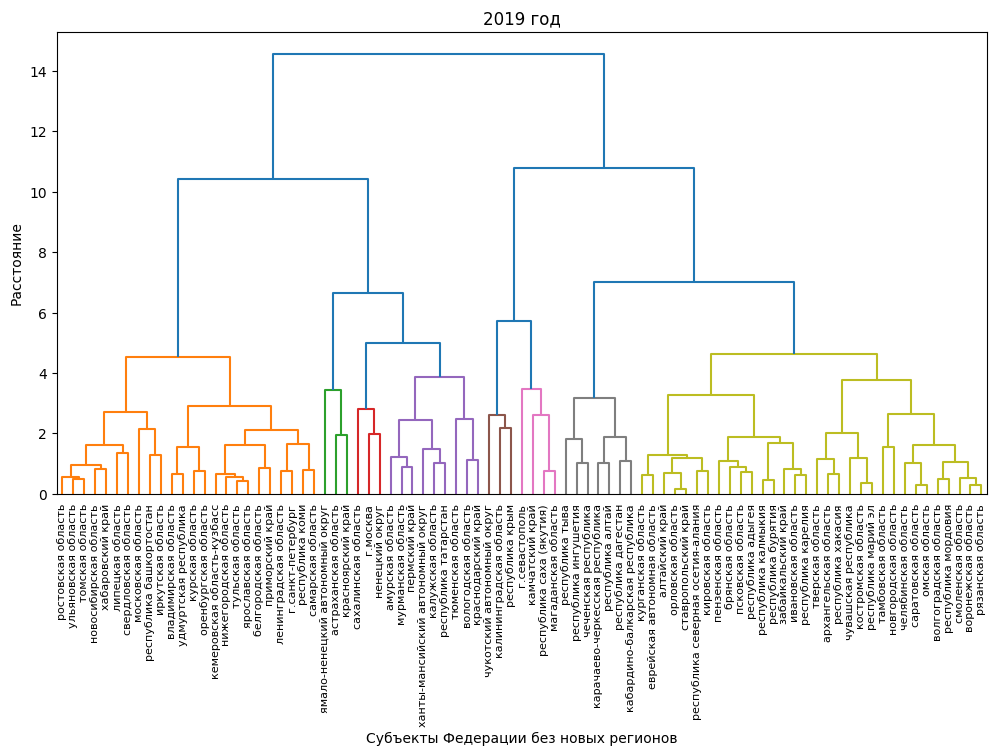

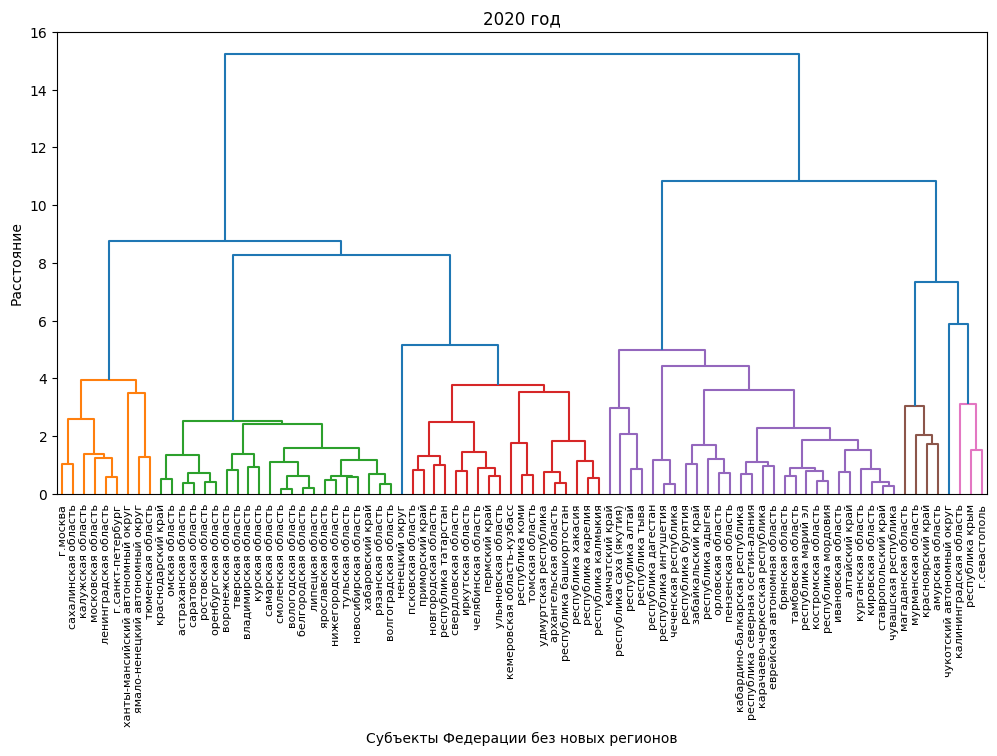

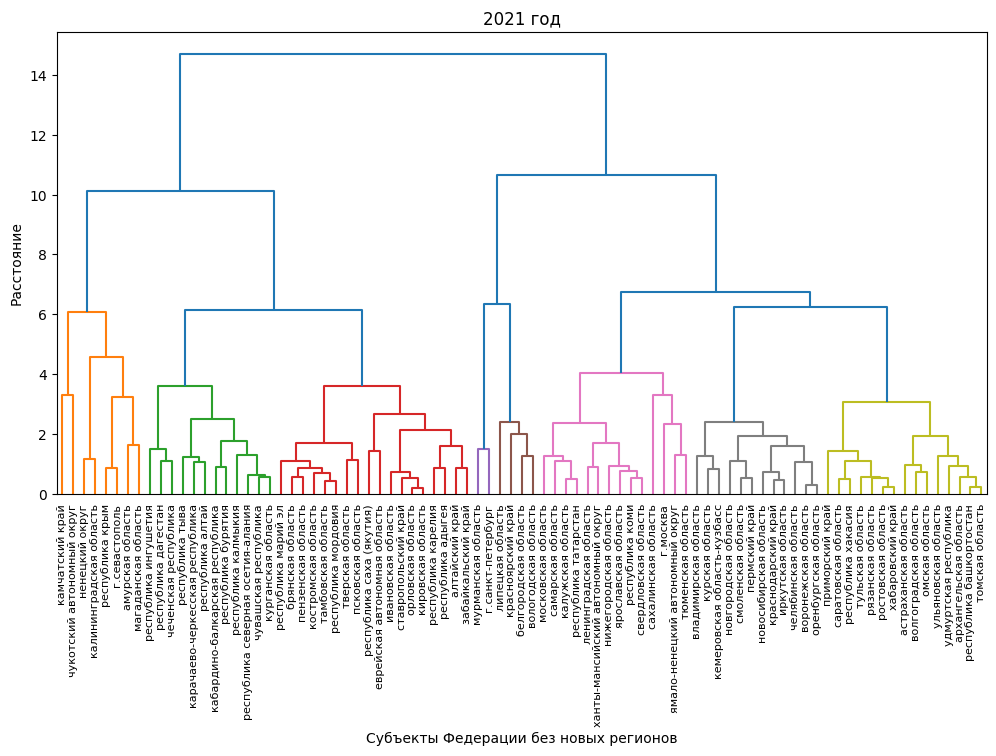

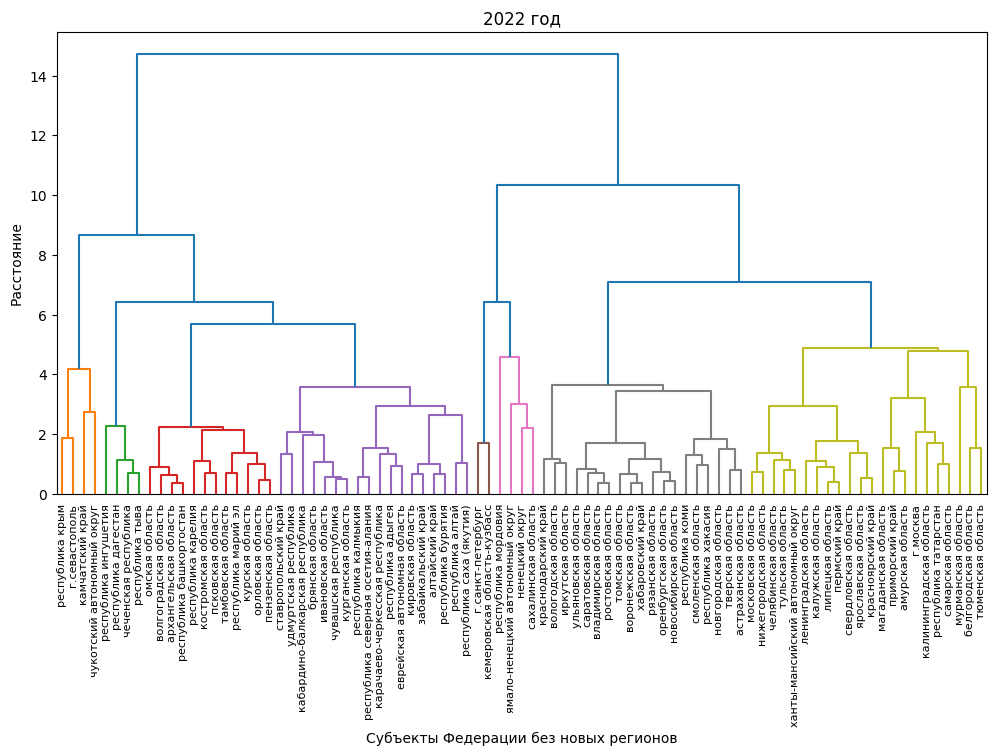

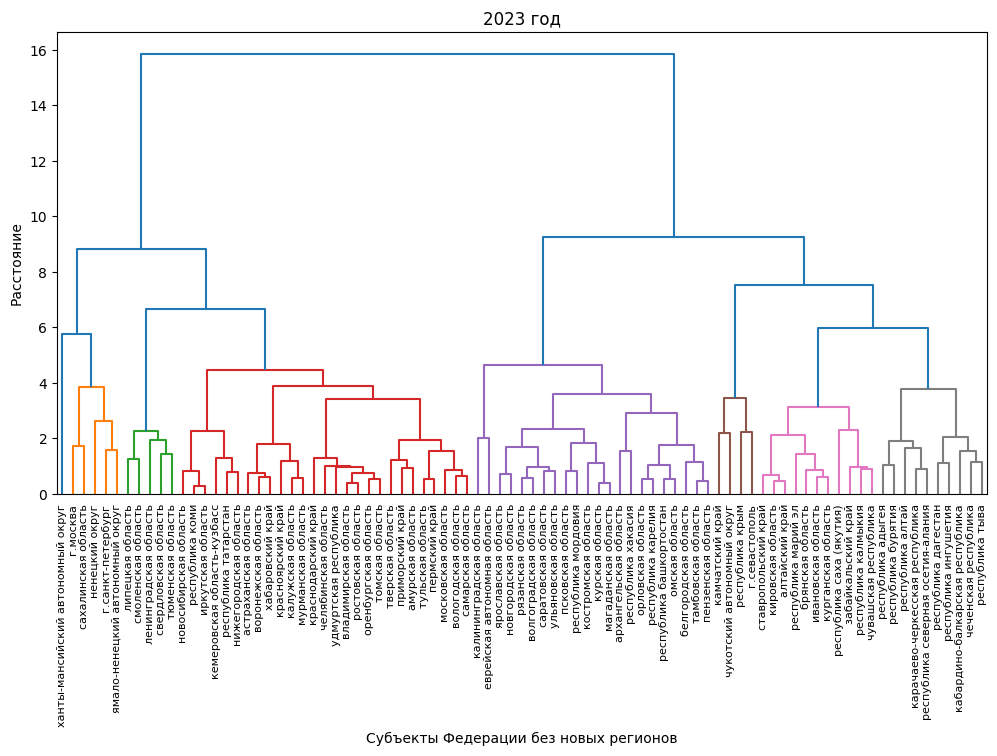

In [10]:
list_of_years = [
    '2019',
    '2020',
    '2021',
    '2022',
    '2023'
]
for year in list_of_years:

    cluster_data = pd.DataFrame([criteria_1[year], 
                                criteria_2[year], 
                                criteria_3[year],
                                criteria_4[year],
                                criteria_5[year]]).T.set_axis([
                    'cr_1', 'cr_2', 'cr_3', 'cr_4', 'cr_5'
                ], axis=1)
    cluster_data = cluster_data.apply(lambda x: (x - np.mean(x))/np.std(x))

    # Кластеризация
    Z = linkage(cluster_data.values, method="ward")

    # Рисуем дендрограмму с подписями
    plt.figure(figsize=(12, 6))
    dendrogram(
        Z,
        labels=cluster_data.index.astype(str),  
        leaf_rotation=90,             
        leaf_font_size=8,
        color_threshold=Z[-7, 2]              
    )
    plt.title(f"{year} год")
    plt.xlabel("Субъекты Федерации без новых регионов")
    plt.ylabel("Расстояние")
    plt.show()

Похоже на 4 или 5 кластеров. Нет постоянства по годам, поэтому сделаем ход конем. Поскольку в каждом критерии берем z-score начальные точки не будут зависеть от года. Поэтому для каждой симуляции найдем ARI между годами (средняя из сочитания 1 из 5) и внутригрупповую дисперсию. Будем выбирать симуляцию, которая дает наиболее устойчивое между годами распределение с поправкой на внутригрупповую дисперсию

In [11]:
nc = 5
n_runs = 10000
ari_list = []
n_years = len(list_of_years)
list_of_sims = []
vars_ = []
for i in range(n_runs):
    sim = []
    var_list = []
    for year in list_of_years:
        cluster_data = pd.DataFrame([criteria_1[year], 
                                    criteria_2[year], 
                                    criteria_3[year],
                                    criteria_4[year],
                                    criteria_5[year]]).T.set_axis([
                    'cr_1', 'cr_2', 'cr_3', 'cr_4', 'cr_5'
                ], axis=1)
        X = cluster_data.apply(lambda x: (x - np.mean(x))/np.std(x))
        km = KMeans(n_clusters=nc, init="random", n_init=1, random_state=i)
        labels = km.fit_predict(X)
        sim.append(labels)
        cluster_data.loc[:, 'cluster'] = labels
        var_list.append(sum([cluster_data.query(f'cluster == {i}').iloc[:, :-1].var(0).sum() for i in range(nc)]))

    # матрица сходства между всеми запусками
    ari_matrix = np.zeros((n_years, n_years))

    for i in range(n_years):
        for j in range(i+1, n_years):
            ari = adjusted_rand_score(sim[i], sim[j])
            ari_matrix[i, j] = ari
            ari_matrix[j, i] = ari
    ari_list.append(ari_matrix[np.triu_indices(n_years, 1)].mean())
    list_of_sims.append(sim)
    vars_.append(np.mean(var_list))
searching_df = pd.DataFrame([ari_list, vars_]).T.set_axis(['ari', 'varience'], axis=1).sort_values('ari', ascending=False)
print(f"Среднее ARI: {np.mean(ari_list).round(3)}\n"
      f"Нижний дециль {np.quantile(ari_list, q = 0.1).round(3)}\n"
      f"Верхний дециль {np.quantile(ari_list, q = 0.9).round(3)}\n"
      f"Симуляция с самым устойчивым разбиением: {ari_list.index(max(ari_list))}, ARI {max(ari_list)}")


Среднее ARI: 0.313
Нижний дециль 0.248
Верхний дециль 0.392
Симуляция с самым устойчивым разбиением: 8675, ARI 0.5604677049713351


Получается, что самое лучшее разбиение все равно так или иначе вариация разбиения на два, а это значит, что кластеризация по-большому счету бессмыслена.

In [12]:
list_of_sims[8675]

[array([0, 4, 0, 0, 4, 1, 4, 0, 0, 1, 4, 0, 0, 4, 0, 0, 0, 1, 4, 0, 1, 0,
        0, 3, 1, 0, 0, 4, 1, 4, 4, 3, 0, 2, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4,
        0, 4, 0, 1, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 1, 2, 2, 0, 4, 4,
        0, 4, 2, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 4, 1, 4, 3],
       dtype=int32),
 array([2, 4, 2, 2, 4, 1, 4, 2, 2, 1, 4, 2, 2, 4, 2, 2, 2, 1, 2, 2, 0, 2,
        2, 3, 1, 2, 2, 2, 1, 4, 4, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4,
        2, 4, 4, 2, 2, 4, 2, 4, 2, 2, 4, 2, 2, 2, 4, 2, 1, 1, 1, 2, 4, 4,
        2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 3, 2, 2, 3, 3, 1, 4, 3],
       dtype=int32),
 array([0, 4, 2, 2, 4, 1, 4, 2, 0, 1, 4, 2, 2, 4, 2, 2, 2, 1, 4, 2, 1, 2,
        0, 3, 1, 0, 2, 4, 1, 4, 4, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4,
        2, 4, 4, 1, 2, 4, 2, 4, 2, 2, 4, 1, 2, 2, 4, 2, 1, 1, 1, 2, 4, 4,
        2, 4, 0, 2, 2, 2, 2, 2, 4, 4, 4, 3, 2, 2, 3, 3, 2, 4, 3],
       dtype=int32),
 array([1, 4, 2, 2, 4, 2, 2, 4, 1, 1, 4, 2, 2, 4, 2, 1, 2, 1, 4, 2, 0, 2,

In [13]:
searching_df

,ari,varience
8675,0.560468,0.128455
8741,0.553281,0.167040
2226,0.551723,0.149142
2814,0.547727,0.131283
8114,0.545922,0.140629
...,...,...
7644,0.180614,0.129803
5277,0.179683,0.148690
1921,0.176681,0.132708
2982,0.168503,0.119804


In [15]:
SIM = 8675
results = []
for year in list_of_years:
    cluster_data = pd.DataFrame([criteria_1[year], 
                                criteria_2[year], 
                                criteria_3[year],
                                criteria_4[year],
                                criteria_5[year]]).T.set_axis([
                'Доля дотаций в МБТ', 
                'Соотношение совокупных доходов к совокупным расходам', 
                'Средний темп роста номинального ВРП за последние три года',
                'Доля собственных доходов в доходах', 
                'Доля социальных расходов в совокупных расходах'
            ], axis=1)
    cluster_data['cluster'] = list_of_sims[SIM][list_of_years.index(year)]
    results += [cluster_data.groupby("cluster").agg(["mean", "std", "min", "max", "count"])]

results.append(pd.DataFrame(list_of_sims[SIM]).T.set_axis(list_of_years, axis = 1).set_axis(vrp.index, axis = 0))


In [19]:
with pd.ExcelWriter("output.xlsx") as writer:
    for df, sheet in zip(results, list_of_years + ['Разбиение']):
        df.to_excel(writer, sheet_name=sheet, index=True)

In [1]:
list_of_sims = [x.tolist() for xs in list_of_sims for x in xs]
def consensus_matrix(labels_runs):
    n_samples = len(labels_runs[0])
    n_runs = len(labels_runs)
    M = np.zeros((n_samples, n_samples))

    for labels in labels_runs:
        for i in range(n_samples):
            for j in range(n_samples):
                if labels[i] == labels[j]:
                    M[i, j] += 1

    return M / n_runs

M = consensus_matrix(list_of_sims)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(M, cmap="viridis", annot=True)
plt.show()

NameError: name 'list_of_sims' is not defined

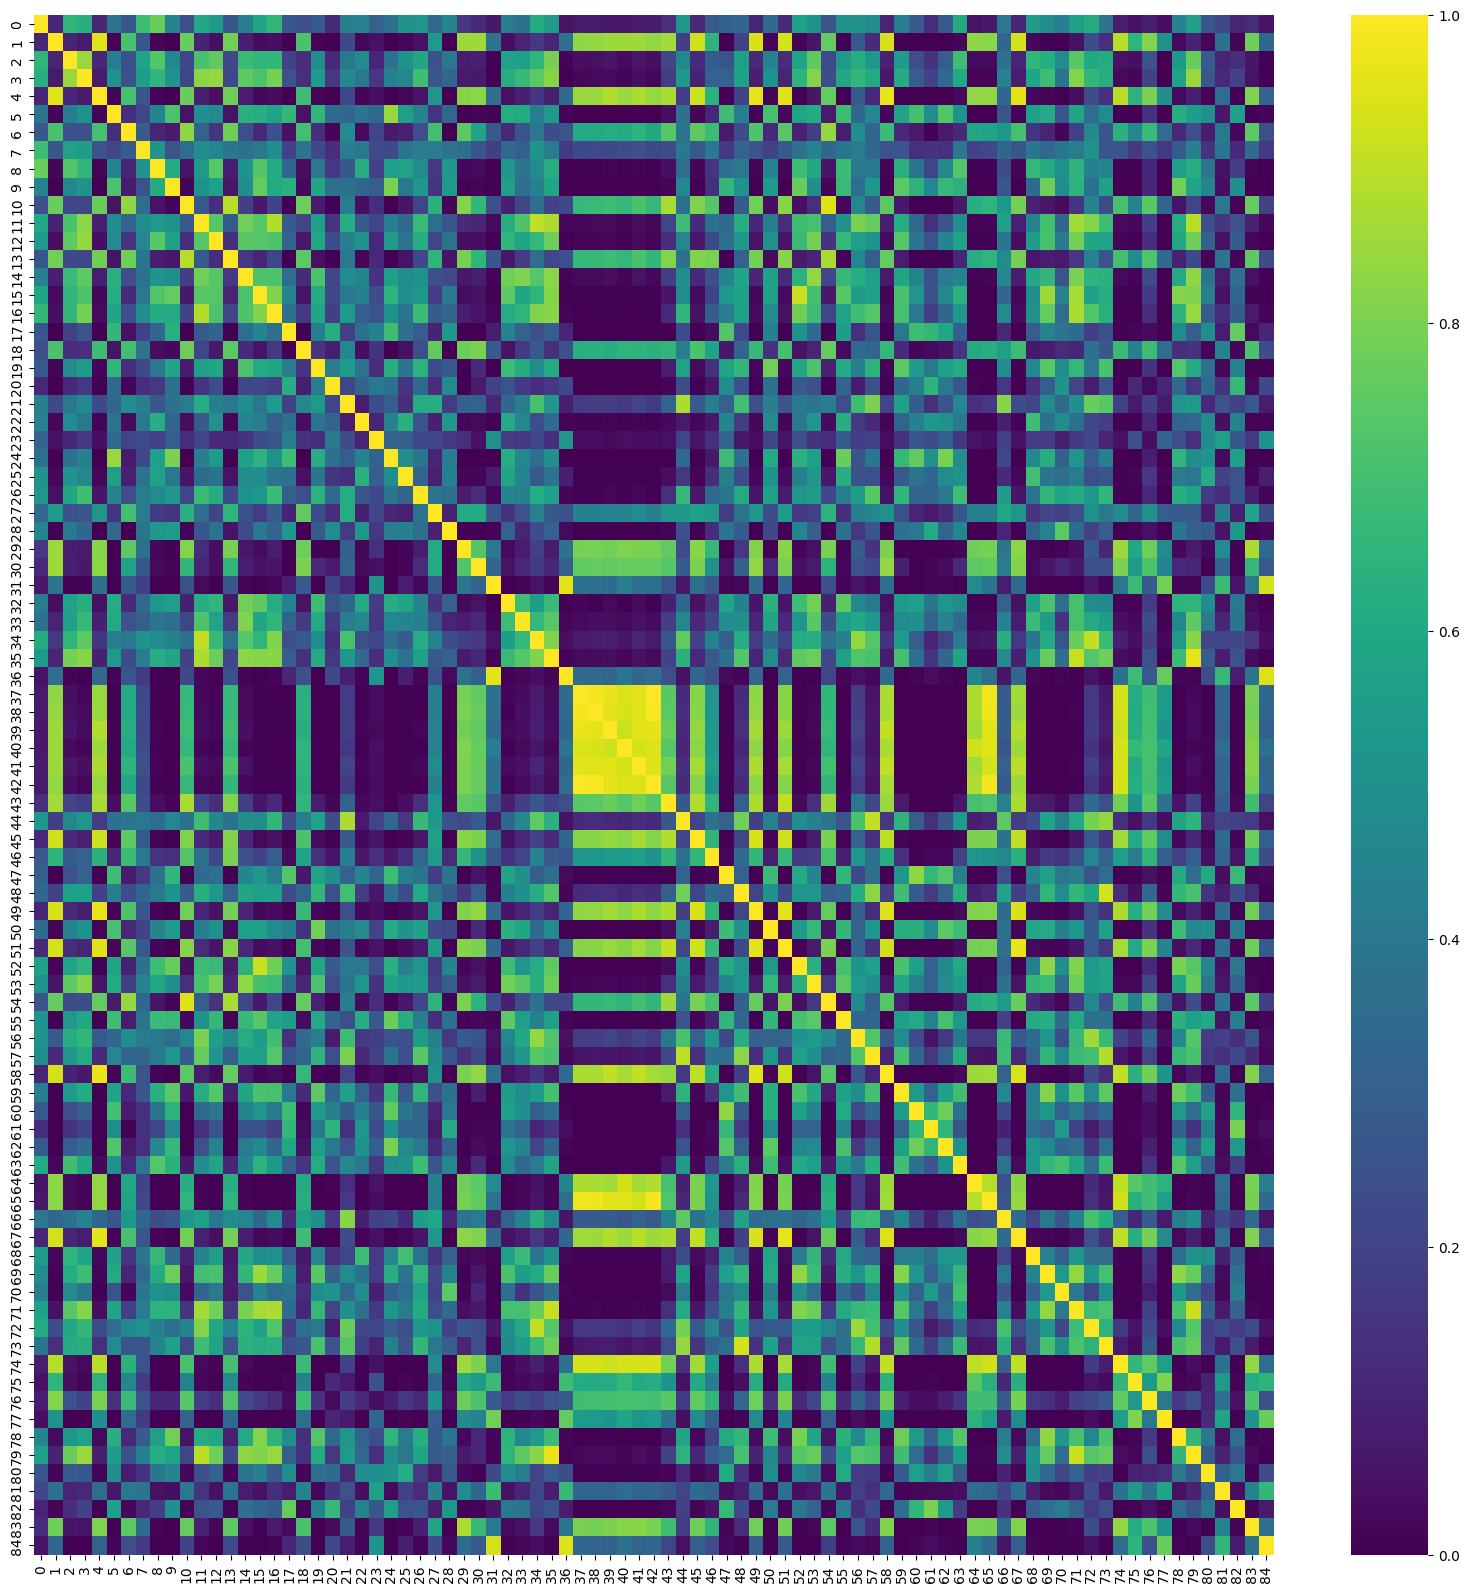

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    M, 
    cmap="viridis",     # цветовая схема
    cbar=True           # показывать цветовую шкалу
)
plt.show()

##### Кластеризация

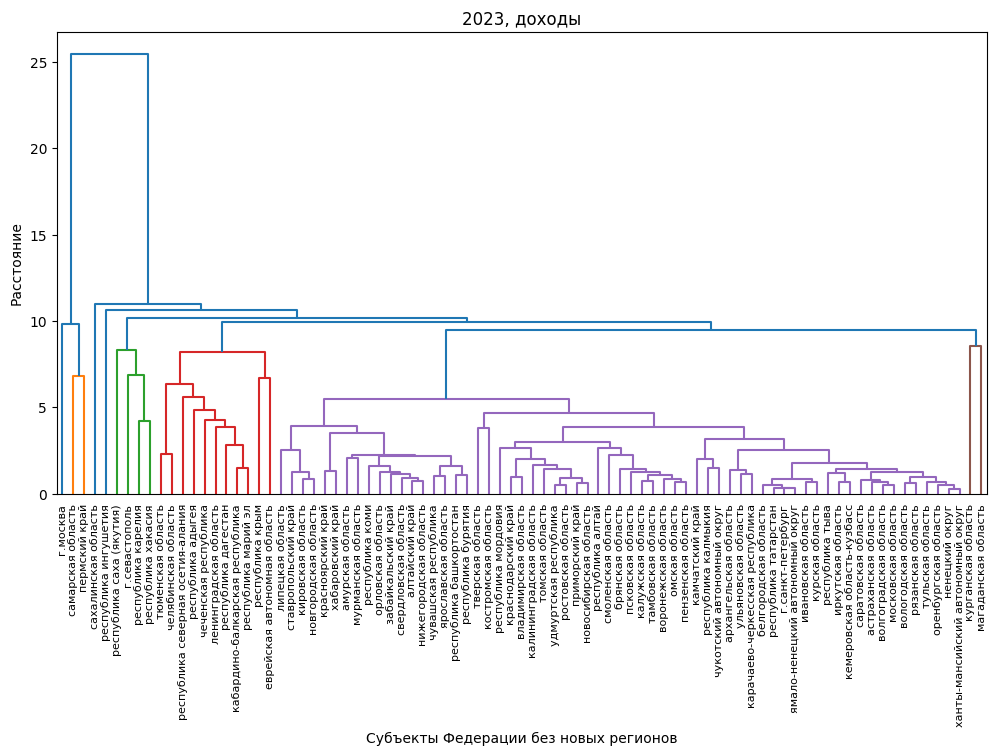

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year]

for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

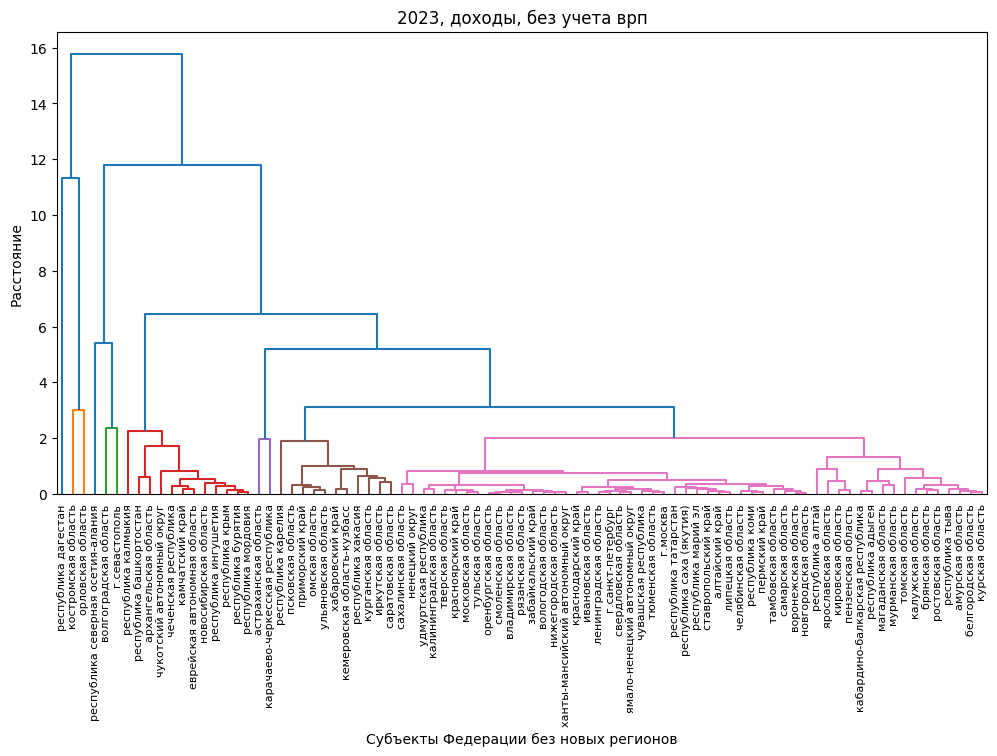

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    try:
        df.loc[name, :] = (df.loc[name, :]/df.loc[name, :].sum(0)).round().copy()
    except:
        print(name)
# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы, без учета врп")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

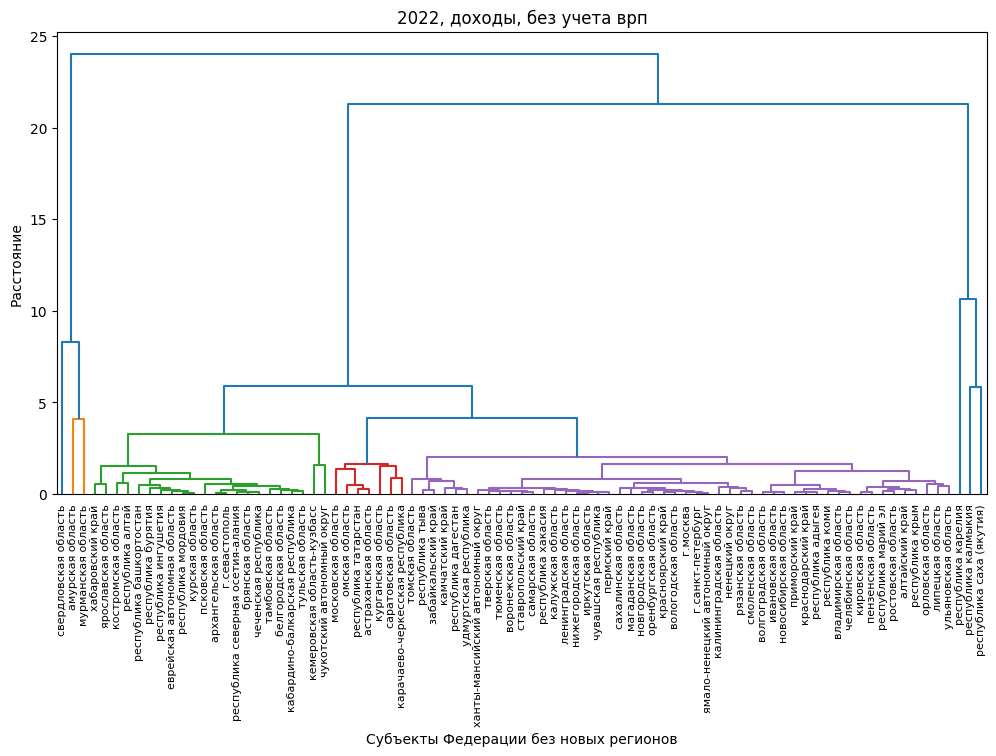

In [ ]:
year = str(2022)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    try:
        df.loc[name, :] = (df.loc[name, :]/df.loc[name, :].sum(0)).round().copy()
    except:
        print(name)
# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы, без учета врп")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

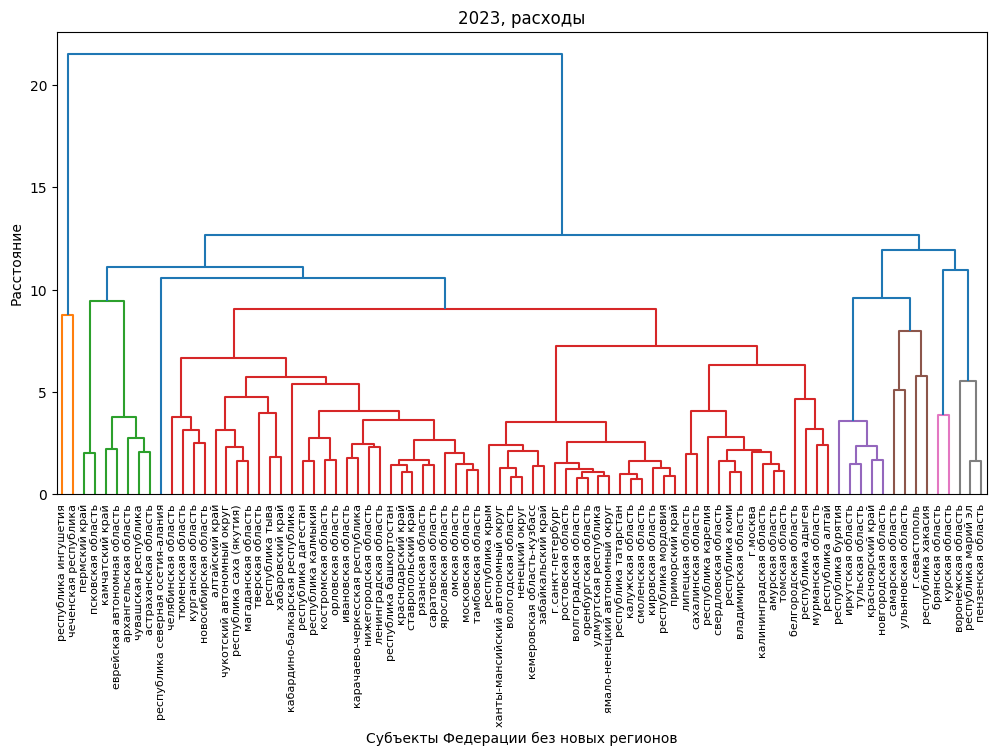

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['cost'])
for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year]

for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, расходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

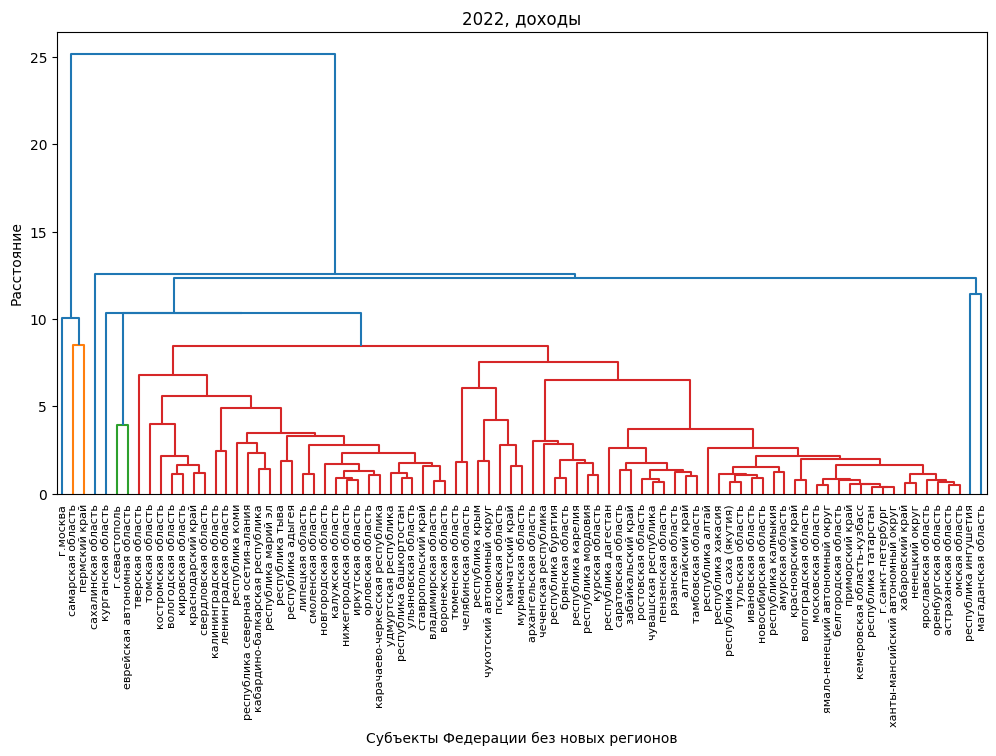

In [ ]:
year = str(2022)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year]

for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

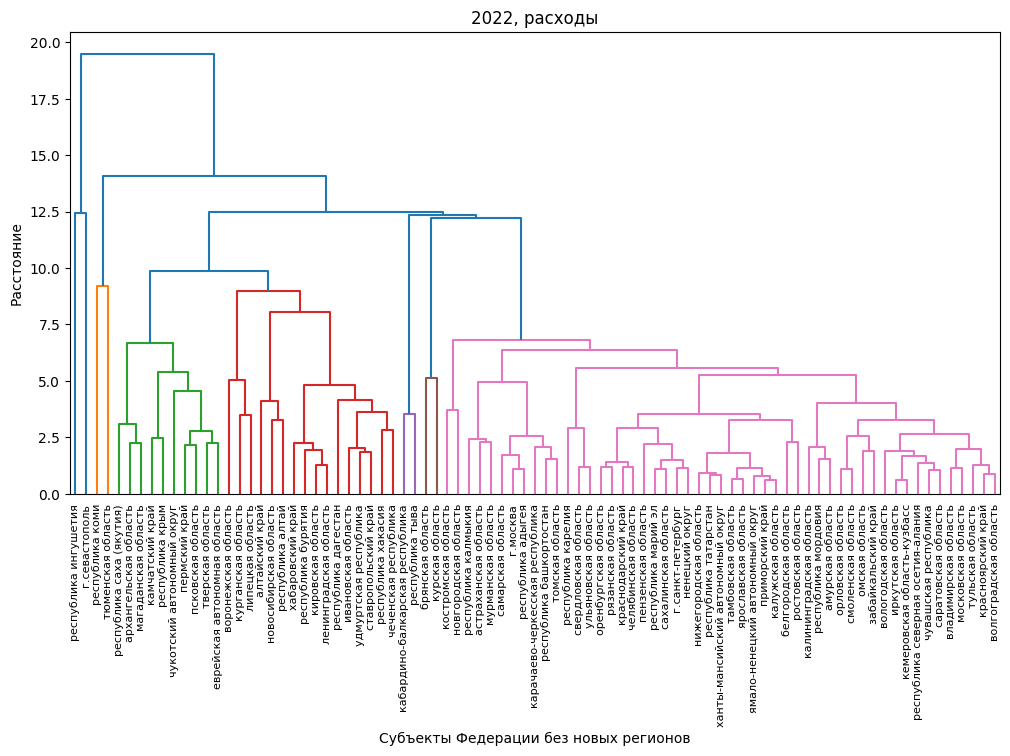

In [ ]:
year = str(2022)
df = pd.DataFrame(years[year]['cost'])
for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year]

for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, расходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

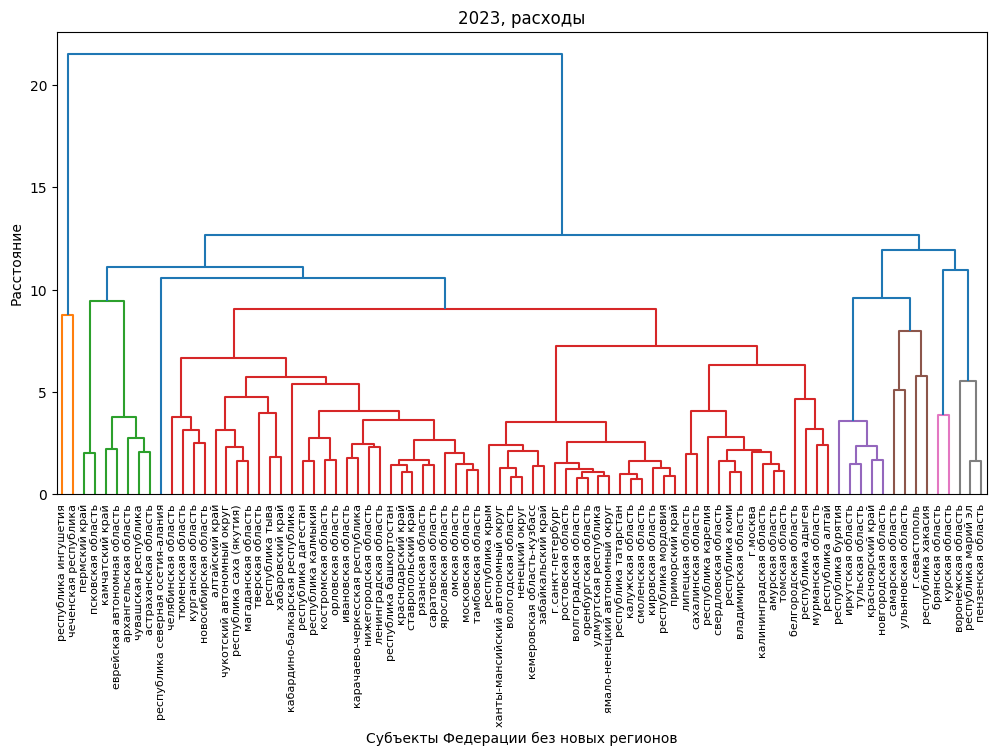

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['cost'])
for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year]

for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, расходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

In [ ]:
df

,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300
name,,,,,,,,,,,,,
республика башкортостан,0.64105,0.23429,0.3976,-0.11333,0.63255,0.54078,0.48088,0.43678,0.078,0.46495,-0.62055,0.25923,0.35284
республика бурятия,0.24187,0.23274,-0.58109,0.54656,-0.20993,-3.85189,0.33651,0.46114,0.03101,-1.67692,0.39076,0.15707,-0.52538
республика дагестан,0.33839,0.23256,-0.27564,0.81004,-0.12393,0.86503,-1.26777,0.176,-0.53991,0.48504,0.1445,-0.71373,0.50083
кабардино-балкарская республика,0.47792,-0.11182,0.43378,-1.06518,1.09148,0.816,0.04964,0.21656,0.30154,-0.10897,0.39448,-3.57601,0.52484
республика калмыкия,0.39556,0.04986,0.08904,0.19484,0.40248,0.50812,-1.37365,0.3158,0.21496,0.40047,-0.31408,0.15763,0.52469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ханты-мансийский автономный округ,0.64629,0.23408,0.3804,1.31531,1.05436,-1.08273,0.62435,0.5722,0.69865,0.58214,0.03654,-0.01985,0.48257
чукотский автономный округ,0.27057,0.23282,0.14383,0.1476,-1.1032,0.51162,0.02568,-1.94271,0.18967,0.3265,0.21939,0.32581,0.52095
ямало-ненецкий автономный округ,0.49931,0.23256,-0.02033,0.25302,0.94806,0.69012,0.74283,0.65813,0.84519,0.48499,0.39161,0.31711,0.52485
